# Lab -- Temporal Graph Neural Networks

Today we will work with temporal graph networks ([TGN](https://arxiv.org/abs/2006.10637))

We will predict the interactions in the common baseline wikipedia dataset.

The Wikipedia is a network of links between editors and Wikipedia pages (an edge corresponds to page editing). The text content of the edited page is represented as a vector, which components are attributes of the corresponding edge. In addition, each user is associated with a label of whether he is banned or not.

Let us download it.

In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
! wget https://www.dropbox.com/s/hkhahv2p595ly32/data.zip
! unzip data.zip

--2022-11-25 18:13:32--  https://www.dropbox.com/s/hkhahv2p595ly32/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/hkhahv2p595ly32/data.zip [following]
--2022-11-25 18:13:32--  https://www.dropbox.com/s/raw/hkhahv2p595ly32/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc90ad2553d40e07ed2e6aa484b0.dl.dropboxusercontent.com/cd/0/inline/Bxc8WIQaqkSiAyyYQm8dMOFL21A7kN2MGcF4BZo7IOyUZPoIFuSKSf4nvNJN1SqJQEvgDfCZYlfwtOcSTp9Eh8WgfZBI3UNu7QIJI1Aq1yD4A15QoSge4IL2CXDdYJg9TSBX6qsF8RKkFvIdyM8_NYr7sClNcBTR8XmDTL7i5qUBRQ/file# [following]
--2022-11-25 18:13:33--  https://uc90ad2553d40e07ed2e6aa484b0.dl.dropboxusercontent.com/cd/0/inline/Bxc8WIQaqkSiAyyYQm8dMOFL21A7kN2MGcF4BZo7IOyUZPoIFuSKSf4nvNJN1SqJQEvgDfCZYlfwtOcSTp9Eh8WgfZBI

Dataset consist of three parts: edgelist `ml_wikipedia.csv`, edge features `ml_wikipedia.npy` and node features `ml_wikipedia_node.npy`.

In [3]:
graph_df = pd.read_csv("ml_wikipedia.csv")
graph_df = graph_df.sort_values("ts")
edge_features = np.load("ml_wikipedia.npy")
node_features = np.load("ml_wikipedia_node.npy")

In [4]:
node_features = torch.from_numpy(node_features).float()
edge_features = torch.from_numpy(edge_features).float()

In [5]:
graph_df.head()

,Unnamed: 0,u,i,ts,label,idx
0,0,1,8228,0.0,0,1
1,1,2,8229,36.0,0,2
2,2,2,8229,77.0,0,3
3,3,3,8230,131.0,0,4
4,4,2,8229,150.0,0,5


The models are inductive, i.e. should work good enough on unseen previously nodes and edges. So let us split our dataset on train, validation and test parts in following fashion:

1. Split dataset by some threshold time
2. Select part of a nodes that appear on the test time period and remove if from the train dataset

In [6]:
import random

random.seed(0)

node_set = set(graph_df.u) | set(graph_df.i)

# 70% of time is train, 15% is validation and 15% is test
val_time, test_time = list(np.quantile(graph_df.ts, [0.70, 0.85]))

test_node_set = set(graph_df[graph_df.ts > val_time].u) | set(graph_df[graph_df.ts > val_time].i)

test_node_set = set(random.sample(test_node_set, int(0.1 * len(node_set))))

In [7]:
test_node_mask = graph_df.u.isin(test_node_set) | graph_df.i.isin(test_node_set)

train_mask = (graph_df.ts <= val_time) & (~test_node_mask)  # in order not to use nodes from test
val_mask = (graph_df.ts > val_time) & (graph_df.ts <= test_time)
test_mask = (graph_df.ts > test_time)

new_nodes = node_set - set(graph_df.u[train_mask]) - set(graph_df.i[train_mask])

new_node_val_mask = val_mask & (graph_df.u.isin(new_nodes) | graph_df.i.isin(new_nodes))
new_node_test_mask = test_mask & (graph_df.u.isin(new_nodes) | graph_df.i.isin(new_nodes))

In [8]:
def subgraph_to_dataset(subgraph_df):
  return torch.utils.data.TensorDataset(
      torch.LongTensor(subgraph_df.u.values), # sources
      torch.LongTensor(subgraph_df.i.values), # destinations
      torch.FloatTensor(subgraph_df.ts.values), # timestamps
      torch.LongTensor(subgraph_df.idx.values), # edge index
      torch.LongTensor(subgraph_df.label.values), # label
  )

In [9]:
class NeighborFinder:
    """Finds neighbors of a given set of nodes prior to a given time"""
    def __init__(self, subgraph_df, uniform=True):
        self.prepare_neighbors(subgraph_df)
        self.uniform = uniform
    
    def prepare_neighbors(self, subgraph_df):
        tmp_src = subgraph_df.sort_values("ts").groupby("u")[["i", "idx", "ts"]].agg(list)
        tmp_dst = subgraph_df.sort_values("ts").groupby("i")[["u", "idx", "ts"]].agg(list)
        self.node_to_neighbors = tmp_src["i"].map(torch.LongTensor).to_dict()
        self.node_to_neighbors.update(
            tmp_dst["u"].map(torch.LongTensor).to_dict()
        )
        self.node_to_edge_idxs = tmp_src["idx"].map(torch.LongTensor).to_dict()
        self.node_to_edge_idxs.update(
            tmp_dst["idx"].map(torch.LongTensor).to_dict()
        )
        self.node_to_edge_timestamps = tmp_src["ts"].map(torch.FloatTensor).to_dict()
        self.node_to_edge_timestamps.update(
            tmp_dst["ts"].map(torch.FloatTensor).to_dict()
        )

    def find_before(self, src_idx, cut_time):
        i = torch.searchsorted(self.node_to_edge_timestamps[src_idx], cut_time)
        return self.node_to_neighbors[src_idx][:i], self.node_to_edge_idxs[src_idx][:i], self.node_to_edge_timestamps[src_idx][:i]

In [10]:
train_finder = NeighborFinder(graph_df[train_mask])
full_finder = NeighborFinder(graph_df)

In [11]:
class EdgeSampler:
    """Sample destinations uniformly"""
    def __init__(self, dst_list, seed=0):
        self.dst_list = dst_list
        self.dst_size = len(self.dst_list)
    
    def sample(self):
        i = random.randint(0, self.dst_size - 1)
        return self.dst_list[i]

In [12]:
class TemporalGraphDataset(torch.utils.data.Dataset):
    def __init__(self, subgraph_df, neighbor_finder, n_neighbors=10):
        self.dataset = subgraph_to_dataset(subgraph_df.sort_values("ts"))
        self.neighbor_finder = neighbor_finder
        self.n_neighbors = n_neighbors
        self.random_sampler = EdgeSampler(subgraph_df.i.unique())
    
    def __len__(self):
        return len(self.dataset)
    
    def get_neighbors(self, source, timestamp):
        neighbors, edge_idxs, edge_times = self.neighbor_finder.find_before(source, timestamp)
        if neighbors.shape[0] == 0:
            neighbors, edge_idxs, edge_times = torch.zeros(self.n_neighbors), torch.zeros(self.n_neighbors), torch.zeros(self.n_neighbors)
        else:
            ids = np.random.randint(0, neighbors.shape[0], self.n_neighbors)
            neighbors, edge_idxs, edge_times = neighbors[ids], edge_idxs[ids], edge_times[ids]
            sorted_index = edge_times.argsort()
            neighbors, edge_idxs, edge_times = neighbors[sorted_index], edge_idxs[sorted_index], edge_times[sorted_index]
        return neighbors.long(), edge_idxs.long(), edge_times


    def __getitem__(self, idx):
        source, destination, timestamp, edge_idx, label = self.dataset.__getitem__(idx)
        negative = self.random_sampler.sample()
        neighbors = {
            "source": self.get_neighbors(source.item(), timestamp.item()),
            "positive": self.get_neighbors(destination.item(), timestamp.item()),
            "negative": self.get_neighbors(negative, timestamp.item()),
        }
        return source, destination, negative, timestamp, edge_idx, label, neighbors

In [13]:
train_ds = TemporalGraphDataset(graph_df[train_mask].sort_values("ts"), train_finder)
val_ds = TemporalGraphDataset(graph_df[val_mask].sort_values("ts"), full_finder)
new_node_val_ds = TemporalGraphDataset(graph_df[new_node_val_mask].sort_values("ts"), full_finder)
test_ds = TemporalGraphDataset(graph_df[test_mask].sort_values("ts"), full_finder)
new_node_test_ds = TemporalGraphDataset(graph_df[new_node_test_mask].sort_values("ts"), full_finder)


train_loader = torch.utils.data.DataLoader(train_ds, batch_size=200, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=200, shuffle=False)
new_node_val_loader = torch.utils.data.DataLoader(new_node_val_ds, batch_size=200, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=200, shuffle=False)
new_node_test_loader = torch.utils.data.DataLoader(new_node_test_ds, batch_size=200, shuffle=False)

## Model definition

![](https://github.com/twitter-research/tgn/blob/master/figures/tgn.png?raw=true)

### Embedding

In [14]:
class MergeLayer(nn.Module):
    """Merge node embeddings for getting final edge score"""
    def __init__(self, dim1, dim2, dim3, dim4):
        super(MergeLayer, self).__init__()
        self.fc1 = torch.nn.Linear(dim1 + dim2, dim3)
        self.fc2 = torch.nn.Linear(dim3, dim4)
        self.act = torch.nn.ReLU()

        torch.nn.init.xavier_normal_(self.fc1.weight)
        torch.nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, x1, x2):
        x = torch.cat([x1, x2], dim=1)
        h = self.act(self.fc1(x))
        return self.fc2(h)

class TimeEncode(nn.Module):
    """Functional Time encoding from TGAT"""
    def __init__(self, dimension):
        super(TimeEncode, self).__init__()
        self.dimension = dimension
        self.w = torch.nn.Linear(1, dimension)
        self.w.weight = torch.nn.Parameter((torch.from_numpy(1 / 10 ** np.linspace(0, 9, dimension)))
                                           .float().reshape(dimension, -1))
        self.w.bias = torch.nn.Parameter(torch.zeros(dimension).float())

    def forward(self, t):
        t = t.unsqueeze(dim=2)
        output = torch.cos(self.w(t))
        return output

In [15]:
class TemporalAttentionLayer(nn.Module):
    """Aggregates features of neighbors"""
    def __init__(self, n_node_features, n_neighbors_features, n_edge_features, time_dim, output_dimension):
        super(TemporalAttentionLayer, self).__init__()

        self.n_head = 2

        self.feat_dim = n_node_features
        self.time_dim = time_dim

        self.query_dim = n_node_features + time_dim
        self.key_dim = n_neighbors_features + time_dim + n_edge_features

        self.merger = MergeLayer(self.query_dim, n_node_features, n_node_features, output_dimension)

        self.multi_head_target = nn.MultiheadAttention(embed_dim=self.query_dim,
                                                       kdim=self.key_dim,
                                                       vdim=self.key_dim,
                                                       num_heads=self.n_head,
                                                       dropout=0.1)

    def forward(self, src_node_features, src_time_features, neighbors_features,
                neighbors_time_features, edge_features, neighbors_padding_mask):

        src_node_features_unrolled = torch.unsqueeze(src_node_features, dim=1)

        query = torch.cat([src_node_features_unrolled, src_time_features], dim=2)
        key = torch.cat([neighbors_features, edge_features, neighbors_time_features], dim=2)
        query = query.permute([1, 0, 2]) 
        key = key.permute([1, 0, 2]) 

        invalid_neighborhood_mask = neighbors_padding_mask.all(dim=1, keepdim=True)
        neighbors_padding_mask[invalid_neighborhood_mask.squeeze(), 0] = False


        attn_output, attn_output_weights = self.multi_head_target(query=query, key=key, value=key,
                                                                  key_padding_mask=neighbors_padding_mask)

        attn_output = attn_output.squeeze()
        attn_output_weights = attn_output_weights.squeeze()

        attn_output = attn_output.masked_fill(invalid_neighborhood_mask, 0)
        attn_output_weights = attn_output_weights.masked_fill(invalid_neighborhood_mask, 0)
        attn_output = self.merger(attn_output, src_node_features)

        return attn_output

### Put all together

In [16]:
class TGN(nn.Module):
    def __init__(self, node_features, edge_features):
        super(TGN, self).__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.n_nodes, self.n_node_features = node_features.shape
        self.memory_dim = self.n_node_features
        self.n_edge_features = edge_features.shape[1]
        self.attention_model = TemporalAttentionLayer(self.n_node_features, self.n_node_features, self.n_edge_features, self.n_node_features, self.n_node_features)
        self.affinity = MergeLayer(self.n_node_features, self.n_node_features, self.n_node_features, 1)
        self.time_encoder = TimeEncode(self.n_node_features)
        self.node_features = node_features.to(self.device)
        self.edge_features = edge_features.to(self.device)
        self.message_dim = 2 * self.n_node_features + self.n_edge_features + self.time_encoder.dimension

        self.__init_memory__()
        self.memory_updater = nn.GRUCell(self.message_dim, self.n_node_features)
    
    def __init_memory__(self):
        self.memory = torch.zeros((self.n_nodes, self.n_node_features), device=self.device)
        self.last_update = torch.zeros((self.n_nodes, 1), device=self.device)
        self.last_message = torch.zeros((self.n_nodes, self.message_dim), device=self.device)
        self.last_message_time = torch.zeros((self.n_nodes, 1), device=self.device)
        self.node_with_messages = set()
    
    def forward(self, source, destination, negative, timestamp, edge_idx, neighbors):
        # update memory
        nodes_with_message = list(self.node_with_messages)
        memory = self.memory.clone()
        if len(nodes_with_message) > 0:
            memory[nodes_with_message] = self.memory_updater(self.last_message[nodes_with_message], self.memory[nodes_with_message])

        # calculate embeddings
        source_embedding, destination_embedding, negative_embedding = self.compute_embedding(
            memory, source, destination, negative, timestamp, edge_idx, neighbors
        )

        # save actual edges to memory
        self.memory[source] = memory[source].detach()
        self.memory[destination] = memory[destination].detach()
        self.last_update[source] = self.last_message_time[source]
        self.last_update[destination] = self.last_message_time[destination]

        # preserve messages for future updates
        time_delta = timestamp - self.last_update[source]
        time_delta_encoding = self.time_encoder(time_delta).reshape(-1, self.n_node_features)
        new_source_messages = torch.cat([
          source_embedding, destination_embedding, self.edge_features[edge_idx], time_delta_encoding
        ], dim=1)
        self.last_message[source] = new_source_messages.detach()
        self.last_message_time[source] = timestamp.detach()

        time_delta = timestamp - self.last_update[destination].reshape(-1, 1)
        time_delta_encoding = self.time_encoder(time_delta).reshape(-1, self.n_node_features)
        new_destination_messages = torch.cat([
          destination_embedding, source_embedding, self.edge_features[edge_idx], time_delta_encoding
        ], dim=1)
        self.last_message[destination] = new_destination_messages.detach()
        self.last_message_time[destination] = timestamp.detach()
        self.node_with_messages |= set(source.tolist()) | set(destination.tolist())

        # calculate affinity between embeddings
        scores = self.affinity(
            torch.cat([source_embedding, source_embedding], dim=0),
            torch.cat([destination_embedding, negative_embedding], dim=0),
        ).sigmoid()
        return scores
    
    def compute_embedding(self, memory, source, destination, negative, timestamp, edge_idx, neighbors):
        all_nodes = torch.cat([source, destination, negative])
        all_times = torch.cat([timestamp, timestamp, timestamp])
        node_features = memory[all_nodes] + self.node_features[all_nodes]
        time_embedding = self.time_encoder(torch.zeros_like(all_times))

        neighbor_embeddings, edge_time_embeddings, edge_features, mask = self.compute_neighbors(
            memory, all_times, neighbors
        )
        
        all_embeddings = self.attention_model(node_features,
                                              time_embedding,
                                              neighbor_embeddings,
                                              edge_time_embeddings,
                                              edge_features,
                                              mask)
        return (
            all_embeddings[:source.size(0)],
            all_embeddings[source.size(0):2 * source.size(0)],
            all_embeddings[2 * source.size(0):]
        )

    def compute_neighbors(self, memory, timestamp, neighbors):
        all_nodes = torch.cat([neighbors[k][0] for k in neighbors], dim=0)
        mask = all_nodes == 0
        all_nodes = all_nodes.reshape(-1)
        all_edges = torch.cat([neighbors[k][1] for k in neighbors], dim=0)
        all_times = torch.cat([neighbors[k][2] for k in neighbors], dim=0)
        node_features = memory[all_nodes] + self.node_features[all_nodes]
        node_features = node_features.reshape(all_edges.shape[0], all_edges.shape[1], -1)
        node_features = torch.zeros_like(node_features)

        edge_time_embeddings = self.time_encoder(timestamp - all_times)
        edge_features = self.edge_features[all_edges]
        
        return node_features, edge_time_embeddings, edge_features, mask


Training

In [17]:
from sklearn.metrics import average_precision_score
from matplotlib import pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm

criterion = nn.BCELoss()
def train(model, opt, loader):
    model.train()
    pr_time = None
    for source, destination, negative, timestamp, edge_idx, label, neighbors in tqdm(loader):
        source = source.to(model.device)
        destination = destination.to(model.device)
        negative = negative.to(model.device)
        timestamp = timestamp.to(model.device)
        edge_idx = edge_idx.to(model.device)
        neighbors = {k: [j.to(model.device) for j in v] for k, v in neighbors.items()}

        scores = model(source, destination, negative, timestamp.reshape(-1, 1), edge_idx, neighbors)
        label = torch.cat([torch.ones_like(source, device=model.device), torch.zeros_like(source, device=model.device)]).float()
        loss = criterion(scores, label.view(-1, 1))

        opt.zero_grad()
        loss.backward()
        opt.step()

def evaluate(model, loader):
    model.eval()
    pred = []
    gt = []
    num_batches = 0
    for source, destination, negative, timestamp, edge_idx, label, neighbors in tqdm(loader):
        source = source.to(model.device)
        destination = destination.to(model.device)
        negative = negative.to(model.device)
        timestamp = timestamp.to(model.device)
        edge_idx = edge_idx.to(model.device)
        neighbors = {k: [j.to(model.device) for j in v] for k, v in neighbors.items()}

        pred.append(model(source, destination, negative, timestamp.reshape(-1, 1), edge_idx, neighbors).detach().cpu().numpy())
        num_batches += 1
    gt = [np.concatenate([np.ones(200), np.zeros(200)])] * (num_batches - 1)
    gt += [np.concatenate([np.ones_like(source.detach().cpu().numpy()), np.zeros_like(source.detach().cpu().numpy())])]
    gt = np.concatenate(gt)
    pred = np.concatenate(pred)
    return average_precision_score(gt, pred)


def run(model, opt, train_loader, val_loader, new_node_val_loader, n_epoch):
    ap_log = []
    new_node_ap_log = []
    for epoch in range(n_epoch):

        model.__init_memory__()
        train(model, opt, train_loader)

        train_memory_backup = model.memory.clone()  # memory backup for additional use
        train_last_update_backup = model.last_update.clone()
        ap_log.append(evaluate(model, val_loader))

        val_memory_backup = model.memory.clone()
        val_last_update_backup = model.last_update.clone()
        model.memory = train_memory_backup
        model.last_update = train_last_update_backup
        new_node_ap_log.append(evaluate(model, new_node_val_loader))

        clear_output()
        plt.plot(ap_log, label=f"all nodes")
        plt.plot(new_node_ap_log, label=f"new nodes")
        plt.legend()
        plt.title(f"Best score: {max(ap_log):.4f}, {max(new_node_ap_log):.4f} at epoch: {np.argmax(ap_log)}, last score: {ap_log[-1]:.4f}, {new_node_ap_log[-1]:.4f} at epoch {epoch}")
        plt.show()
    return val_memory_backup, val_last_update_backup

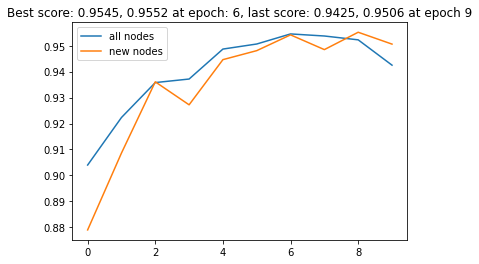

In [18]:
tgn = TGN(node_features, edge_features)
tgn.to(tgn.device)
opt = torch.optim.Adam(tgn.parameters(), 3e-4,)
val_memory_backup, val_last_update_backup = run(tgn, opt, train_loader, val_loader, new_node_val_loader, 10)

In [19]:
ap = evaluate(tgn, test_loader)
print("")
print(f"All nodes AP: {ap}")
tgn.memory = val_memory_backup
tgn.last_update = val_last_update_backup
ap = evaluate(tgn, new_node_test_loader)
print("")
print(f"New nodes AP: {ap}")

100%|██████████| 119/119 [00:09<00:00, 12.77it/s]



All nodes AP: 0.9511688553005719


100%|██████████| 62/62 [00:04<00:00, 12.79it/s]


New nodes AP: 0.9606566312891041
